In [143]:
import gym
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch

In [144]:
env = gym.make('MountainCar-v0')
env.reset()

array([-0.59669447,  0.        ], dtype=float32)

In [145]:
def newreward(pos):
    if (pos >= 0.5):
        return 2
    else:
        return (pos+1.2)/1.8 - 1

In [146]:
def SizeStateSpace(env):
    size_states = (env.observation_space.high - env.observation_space.low) * np.array([10,50])
    size_states = np.around(size_states, 0).astype(int) + 1
    return size_states

In [147]:
def DiscretizeState(env):
    state = env.reset()
    DiscretizedState = (state - env.observation_space.low) * np.array([10,50])
    DiscretizedState = np.round(DiscretizedState, 0).astype(int)
    return DiscretizedState

In [148]:
def QUpdate(learningRate, nextState, nextState_adj, Q_Table, currentState, action):
    delta = learningRate * (newreward(nextState[0]) + np.max(Q_Table[nextState_adj[0], nextState_adj[1]]) - Q_Table[currentState[0], currentState[1],action])
    return delta

In [149]:
def QLearning(env, learningrate, discount, epsilon, min_epsilon, episodes):
    
    #Determine size of discretized state space
    size_states = SizeStateSpace(env)
    
    #Initialize Q table
    Q_Table = np.random.uniform(low = -1, high = 0, size = (size_states[0], size_states[1], env.action_space.n))
    
    #Copy of Q value for plotting purpose
    Qinit = np.copy(Q_Table)
    
    #Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    #Make copy of epsilon
    eps1 = epsilon
    
    #Keep track of first success
    first = episodes + 1
    
    #Run Q Learning Algorithm
    for i in range(episodes):
        #Intialize parameters 
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        #Discretize state
        state_adj = DiscretizeState(env)
        
        while done != True:
            #Render environment for last few epsiodes
            if i >= (episodes - 5) or i < 5:  #episodes % DISPLAY == 0:  #i >= (episodes - 20): 
                env.render()
            
            #Determine next action - epsilon greedy strategy
            if np.random.random() < 1-epsilon:
                action = np.argmax(Q_Table[state_adj[0], state_adj[1]])
            else:
                action = np.random.randint(0, env.action_space.n)
                
            #Get next state and reward
            nextState, reward, done, info = env.step(action)
            
            #Discretize state2
            nextState_adj = (nextState - env.observation_space.low) * np.array([10, 50])
            nextState_adj = np.round(nextState_adj, 0).astype(int)
            
            #Save to Qpoints
            row = np.array([state_adj[0], state_adj[1], action])
            
            #Allow for terminal state
            if done and nextState[0] >= 0.5:
                Q_Table[state_adj[0], state_adj[1], action] = reward
                
            #Adjust Q value for current state
            else:
                delta = QUpdate(learningrate, nextState, nextState_adj, Q_Table, state_adj, action)
                Q_Table[state_adj[0], state_adj[1], action] += delta
            
            #Notifies of any clears
            if nextState[0] >= 0.5 and i < first:
                first = i
                print('First time reaching goal on epsiode {}'.format(i+1))
            
            #Update variables
            tot_reward += newreward(nextState[0])
            state_adj = nextState_adj
        
        #Decay epsilon
        if epsilon > min_epsilon:
            epsilon *= eps1
            
        #Track reward
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
        
        if(i+1) % 100 == 0:
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
    env.close()
    
    return ave_reward_list, Q_Table, Qinit
        

In [150]:
env.reset()
rewards, Qpts, Qinit = QLearning(env, 0.2, 0.9, 0.999, 0, 10000)

Episode 100 Average Reward: -125.13959064500199
Episode 200 Average Reward: -124.708788217273
Episode 300 Average Reward: -124.281844482578
Episode 400 Average Reward: -125.16451558102337
Episode 500 Average Reward: -124.64616038486515
Episode 600 Average Reward: -124.22654481972567
Episode 700 Average Reward: -124.15875877378389
Episode 800 Average Reward: -123.96989121268784
Episode 900 Average Reward: -124.47513066538559
Episode 1000 Average Reward: -123.776802054047
Episode 1100 Average Reward: -124.48505818021708
First time reaching goal on epsiode 1114
Episode 1200 Average Reward: -123.87020619363642
Episode 1300 Average Reward: -122.29191424920137
Episode 1400 Average Reward: -123.20061644846756
Episode 1500 Average Reward: -124.04998487258823
Episode 1600 Average Reward: -121.2214014867284
Episode 1700 Average Reward: -121.2633481232075
Episode 1800 Average Reward: -122.77640591707545
Episode 1900 Average Reward: -121.49519031210451
Episode 2000 Average Reward: -118.30480262057

Text(0.5, 1.0, 'Average Reward vs Episodes')

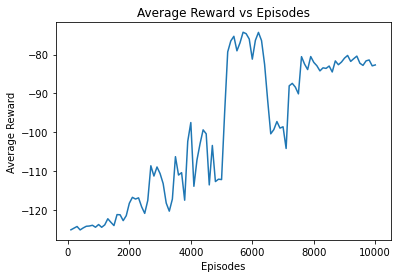

In [151]:
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

initial action counts: [58 52 42]
Final action counts: [51 46 55]


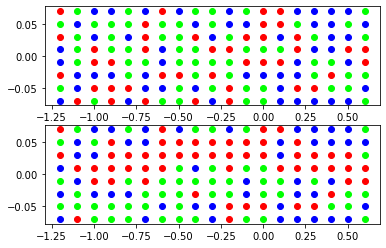

In [152]:
colors = ['lime','blue','red']
labels = ['Left', 'Nothing', 'Right']
fig, (ax1, ax2) = plt.subplots(2)
colorcount2= np.array([0,0,0])
colorcount = np.array([0,0,0])
for i in range(19):
    for j in range(8):
        maxdex2 = np.argmax(Qinit[i][j])
        ax1.plot(i/10-1.2, j/50-0.07, 'o', color = colors[maxdex2])
        colorcount2[maxdex2] +=1
        maxdex = np.argmax(Qpts[i][j])
        ax2.plot(i/10-1.2,j/50-0.07,'o',color = colors[maxdex])
        colorcount[maxdex] += 1
print('initial action counts: {}'.format(colorcount2))
print('Final action counts: {}'.format(colorcount))